### Summary of Akshita's Setup
- **Step 1**: Map compute (N, D) to task loss (bpb on CF continuation). *Only the final checkpoints are used*
- **Step 2**: Map task loss (bpb on CF) to task score (accuracy) using sigmoid.

Additional hacks:
1. **2 additional points**: Additional points added for perfect score (bpb=0.01, accuracy=1) and random chance (bpb=2.6, accuracy=0.25). bpb=2.6 is arbitrarily chosen
2. **Moving average**: Use moving average with window size = 20. 20 is arbitrarily chosen
3. **Expontential moving average**: Use EMA with alpha=0.5
4. **Last n% of points**: Instead of all bpb, only use the last 2% of points per run. 2% is arbitrary.

Notes:
- BoolQ is removed from aggregate scores due to noise

Experimental settings:
- **Easy**: Use every model up to the target model
- **Hard**: Use models with 1/10th the training tokens of the target model

In [1]:
%load_ext autoreload
%autoreload 2

### Setup (Pull W&B Logs)

In [2]:
from olmo.scaling.scaling_laws.download_wandb_logs import main as download_wb
from a_david_noise_utils import get_name_size_length
from argparse import Namespace
import os
import itertools

WANDB_RESULTS = "wandb/peteish-final"
FIGURES = "figures"

run_names = [
    f"ai2-llm/olmo-ladder/peteish-final-{size}-{length}"
    for size, length in itertools.product(["190M", "370M", "600M", "760M", "1B"], ["1xC", "2xC", "5xC", "10xC"])
]

validation_outputs = {}
for run_name in run_names:
    if "peteish7" in run_name:
        output_name = "peteish7"
    else:
        output_name = run_name.split("/")[-1]
        name, size, length = get_name_size_length(run_name)
        output_name = f"{size}-{length}"
    output_path = f"{WANDB_RESULTS}/{output_name}.csv"
    args = Namespace(
        wandb_names=[run_name],
        x_axis="throughput/total_tokens",
        y_axis=["eval/validation-and-bpb-and-downstream"],
        output_path=output_path,
    )
    if not os.path.exists(output_path):
        download_wb(args)
    validation_outputs[output_name] = output_path

/Users/dhei/miniconda3/envs/olmo/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Hard Setting

In [16]:
import ladder_peteish as ladder

# Find the model size corresponding to 10x less compute
all_flops = []
for size in ["190M", "370M", "600M", "760M", "1B"]:
    paths = []
    for length in ["1xC", "2xC", "5xC", "10xC"]:
        if size == "3B" and length == "10xC":
            break
        model_flops = ladder.MODEL_GFLOPS[size]
        length_in_tokens = ladder.parse_length(length, ladder.parse_size(size))
        total_flops = (model_flops * length_in_tokens) / 1e18
        all_flops.append((f"{size}-{length}", total_flops))
sorted_by_flops = sorted(all_flops, key=lambda x:x[1])
corresponding_flops_10x = {
    "1B-10xC": "1B-1xC",
}

# for tup in sorted_by_flops:
#     print(tup)
# print("Using generous upper-bounds to find nearest corresponding 10x less flops run")
# for key, val in corresponding_flops_10x.items():
#     print(f"{key} uses upto {val}")

In [19]:
from a_david_noise_utils import COLOR_MAP
from olmo.scaling.scaling_laws.utils import FinalConfig

all_configs = []

for run_name, max_train_run in corresponding_flops_10x.items():
    configs_size = {}
    for (train_run, _) in sorted_by_flops:
        
        train_size, train_length = train_run.split("-")
        if train_size in configs_size:
            configs_size[train_size]["paths"].append(f"wandb/peteish-final/{train_run}.csv")
        else:
            configs_size[train_size] = {
                "paths": [f"wandb/peteish-final/{train_run}.csv"],
                "mode": "train",
                "n": ladder.MODEL_PARAMS[train_size],
                "label": train_size,
                "color": COLOR_MAP[train_size]
            }

        if train_run == max_train_run:
            break

    size, length = run_name.split("-")
    configs_size[f"{size}-{length}"] = {
        "paths": [f"wandb/peteish-final/{run_name}.csv"],
        "mode": "eval",
        "n": ladder.MODEL_PARAMS[size],
        "label": size,
        "color": COLOR_MAP[size]
    }
    configs_size = {name: FinalConfig(**config) for name, config in configs_size.items()}
    all_configs.append(configs_size)

#### Predicting 1B at 10xC

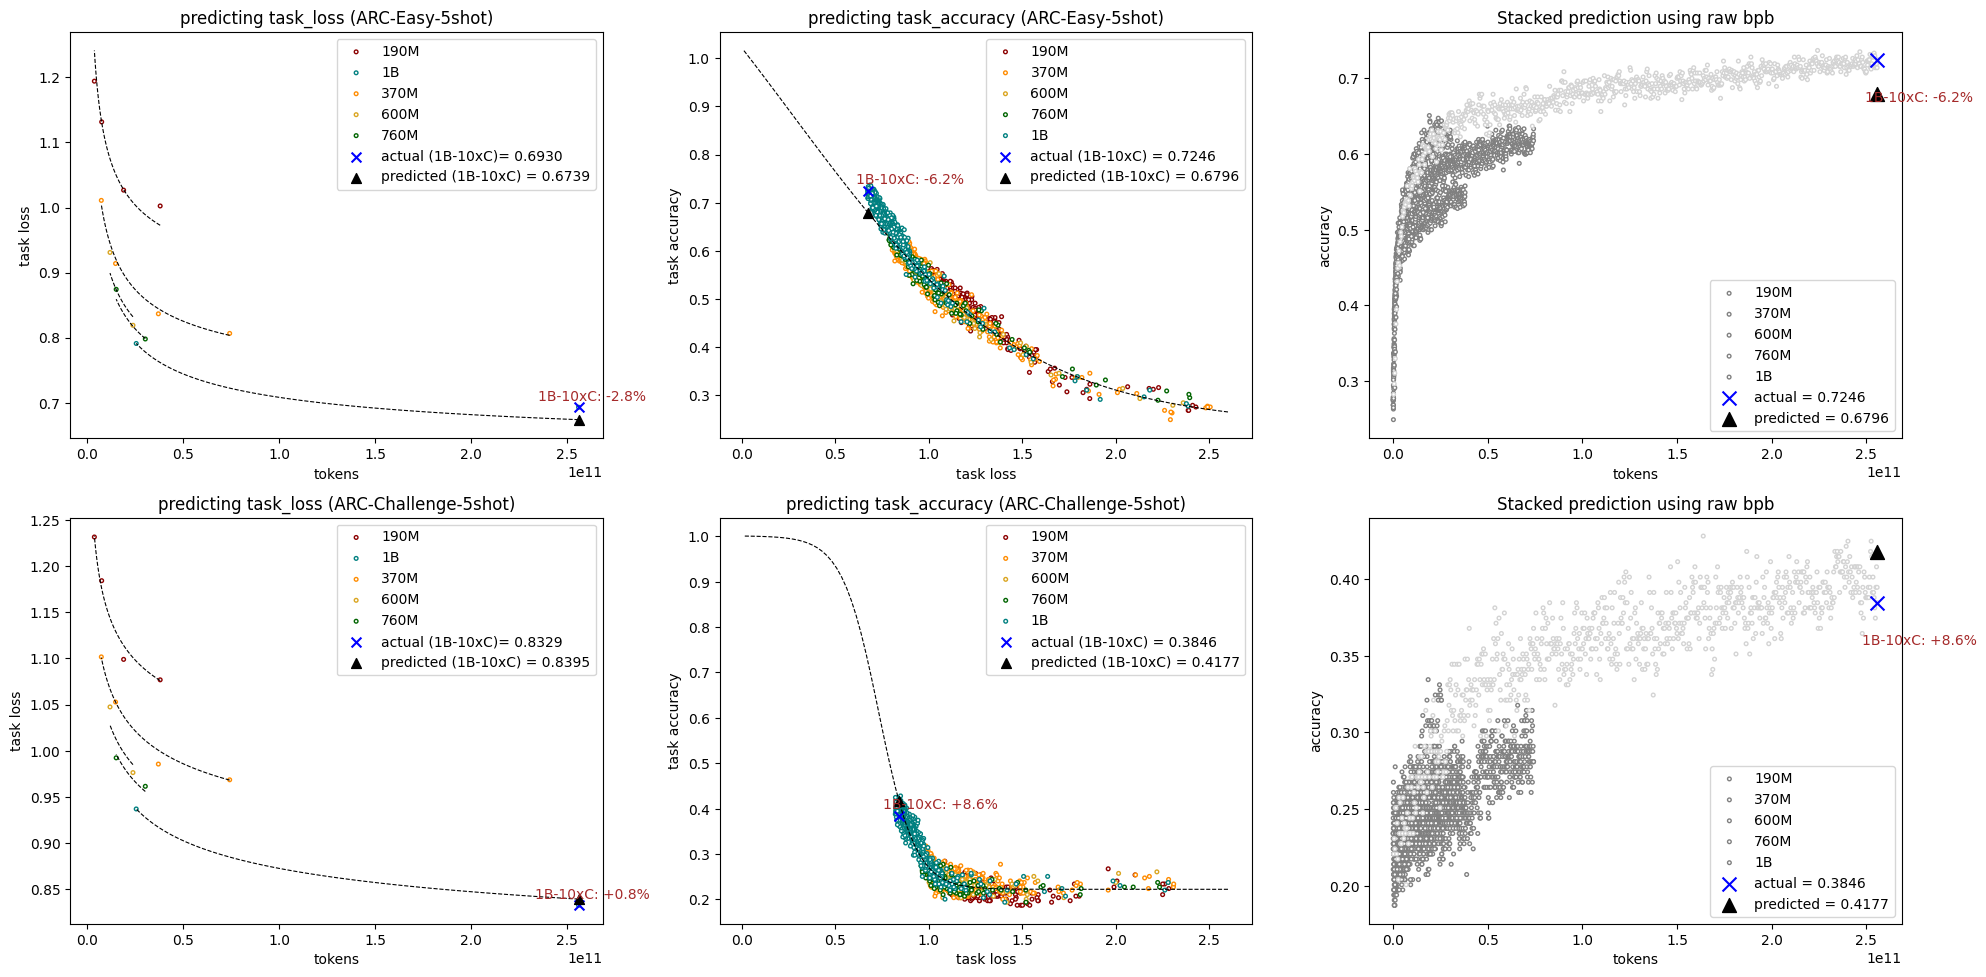

In [38]:
from a_david_noise_utils import get_all_data_by_name, get_dataframe, plot_step1, plot_step2, fit_step1, fit_step2, get_predicted_error, plot_stacked
from a_david_noise_utils import BASELINE_BY_TASK_NAME, TASKS

import matplotlib.pyplot as plt

rows = len(TASKS.keys())
fig, axes = plt.subplots(rows, 3, figsize=(20, 5 * rows))

step1_error = {}
stacked_error = {}

for configs in all_configs:
    target = [run_name for run_name in configs if configs[run_name].mode == "eval"][0]
    step1_error[target] = {}
    stacked_error[target] = {}

    for i, (task_name, task) in enumerate(TASKS.items()):
        tokens = get_all_data_by_name(configs, ["throughput/total_tokens"])
        bpb_loss = get_all_data_by_name(configs, task['bpb'])
        downstream_loss = get_all_data_by_name(configs, task['score'])
    
        df = get_dataframe(configs, tokens, downstream_loss)
        
        step1_df = get_dataframe(configs, tokens, bpb_loss)
        step1_df = step1_df.groupby('run').apply(lambda rows: rows.iloc[-1], include_groups=False).reset_index()
        step1_df, coefficients = fit_step1(step1_df)

        # Only plot for the final prediction
        do_plot = "1B-10xC" in configs

        if do_plot:
            plot_step1(
                step1_df,
                coefficients,
                axes[i][0],
                x_label="tokens",
                y_label="task loss",
                title=f"predicting task_loss ({task_name})",
                do_label=True,
            )
        
        step1_error[target][task_name] = get_predicted_error(step1_df)

        step2_df = get_dataframe(configs, bpb_loss, downstream_loss)
        last_match_idx = step2_df.loc[step2_df["mode"]=="eval"].tail(1).index
        step2_df.loc[last_match_idx, 'x'] = step1_df[step1_df["mode"]=="eval"].predicted_y.values[0]
    
        step2_df, coefficients = fit_step2(step2_df, BASELINE_BY_TASK_NAME[task_name])
        if do_plot:
            plot_step2(
                step2_df,
                coefficients,
                axes[i][1], x_label="task loss",
                y_label="task accuracy",
                title=f"predicting task_accuracy ({task_name})",
                do_label=True,
            )

        stacked_error[target][task_name] = get_predicted_error(step2_df)

        if do_plot:
            plot_stacked(df, step2_df, axes[i][2], title="Stacked prediction using raw bpb", do_label=True, do_grey=True)

fig.tight_layout()
fig.subplots_adjust(top=0.95)

In [36]:
from a_david_noise_utils import print_error_table

print_error_table(stacked_error)

| Task | Stacked error (1B-10xC) |
| --- | --- |
| ARC-Easy-5shot | -6.2% |
| ARC-Challenge-5shot | +8.6% |
| **Avg signed error** | **+1.2%** |
| **Avg unsigned error** | **+7.4%** |


| Task | Stacked error (1B-10xC) |
| --- | --- |
| ARC-Easy-5shot | -6.2% |
| ARC-Challenge-5shot | +8.6% |
| **Avg signed error** | **+1.2%** |
| **Avg unsigned error** | **+7.4%** |

#### Predicting 7B

In [5]:
import matplotlib.pyplot as plt

import ladder_peteish as ladder
from olmo.scaling.scaling_laws.utils import FinalConfig
from a_david_noise_utils import get_all_data_by_name, get_dataframe, plot_step1, plot_step2, fit_step1, fit_step2, get_predicted_error, plot_stacked
from a_david_noise_utils import BASELINE_BY_TASK_NAME, TASKS, COLOR_MAP

In [6]:
all_runs = []
for size in ["190M", "370M", "600M", "760M", "1B"]:
    paths = []
    for length in ["1xC", "2xC", "5xC", "10xC"]:
        all_runs.append(f"{size}-{length}")
        # model_flops = ladder.MODEL_GFLOPS[size]
        # length_in_tokens = ladder.parse_length(length, ladder.parse_size(size))
        # total_flops = (model_flops * length_in_tokens) / 1e18
        # all_flops.append((f"{size}-{length}", total_flops))

all_configs = []

#for run_name in ["1B-10xC"]:
configs_size = {}
for train_run in all_runs:
    # if train_run == run_name:
    #     break
    train_size, train_length = train_run.split("-")
    if train_size in configs_size:
        configs_size[train_size]["paths"].append(f"wandb/peteish-final/{train_run}.csv")
    else:
        configs_size[train_size] = {
            "paths": [f"wandb/peteish-final/{train_run}.csv"],
            "mode": "train",
            "n": ladder.MODEL_PARAMS[train_size],
            "label": train_size,
            "color": COLOR_MAP[train_size]
        }

# size, length = run_name.split("-")
# configs_size[f"{size}-{length}"] = {
#     "paths": [f"wandb/peteish-final/{run_name}.csv"],
#     "mode": "eval",
#     "n": ladder.MODEL_PARAMS[size],
#     "label": size,
#     "color": color_map[size]
# }
configs_size = {name: FinalConfig(**config) for name, config in configs_size.items()}
all_configs.append(configs_size)

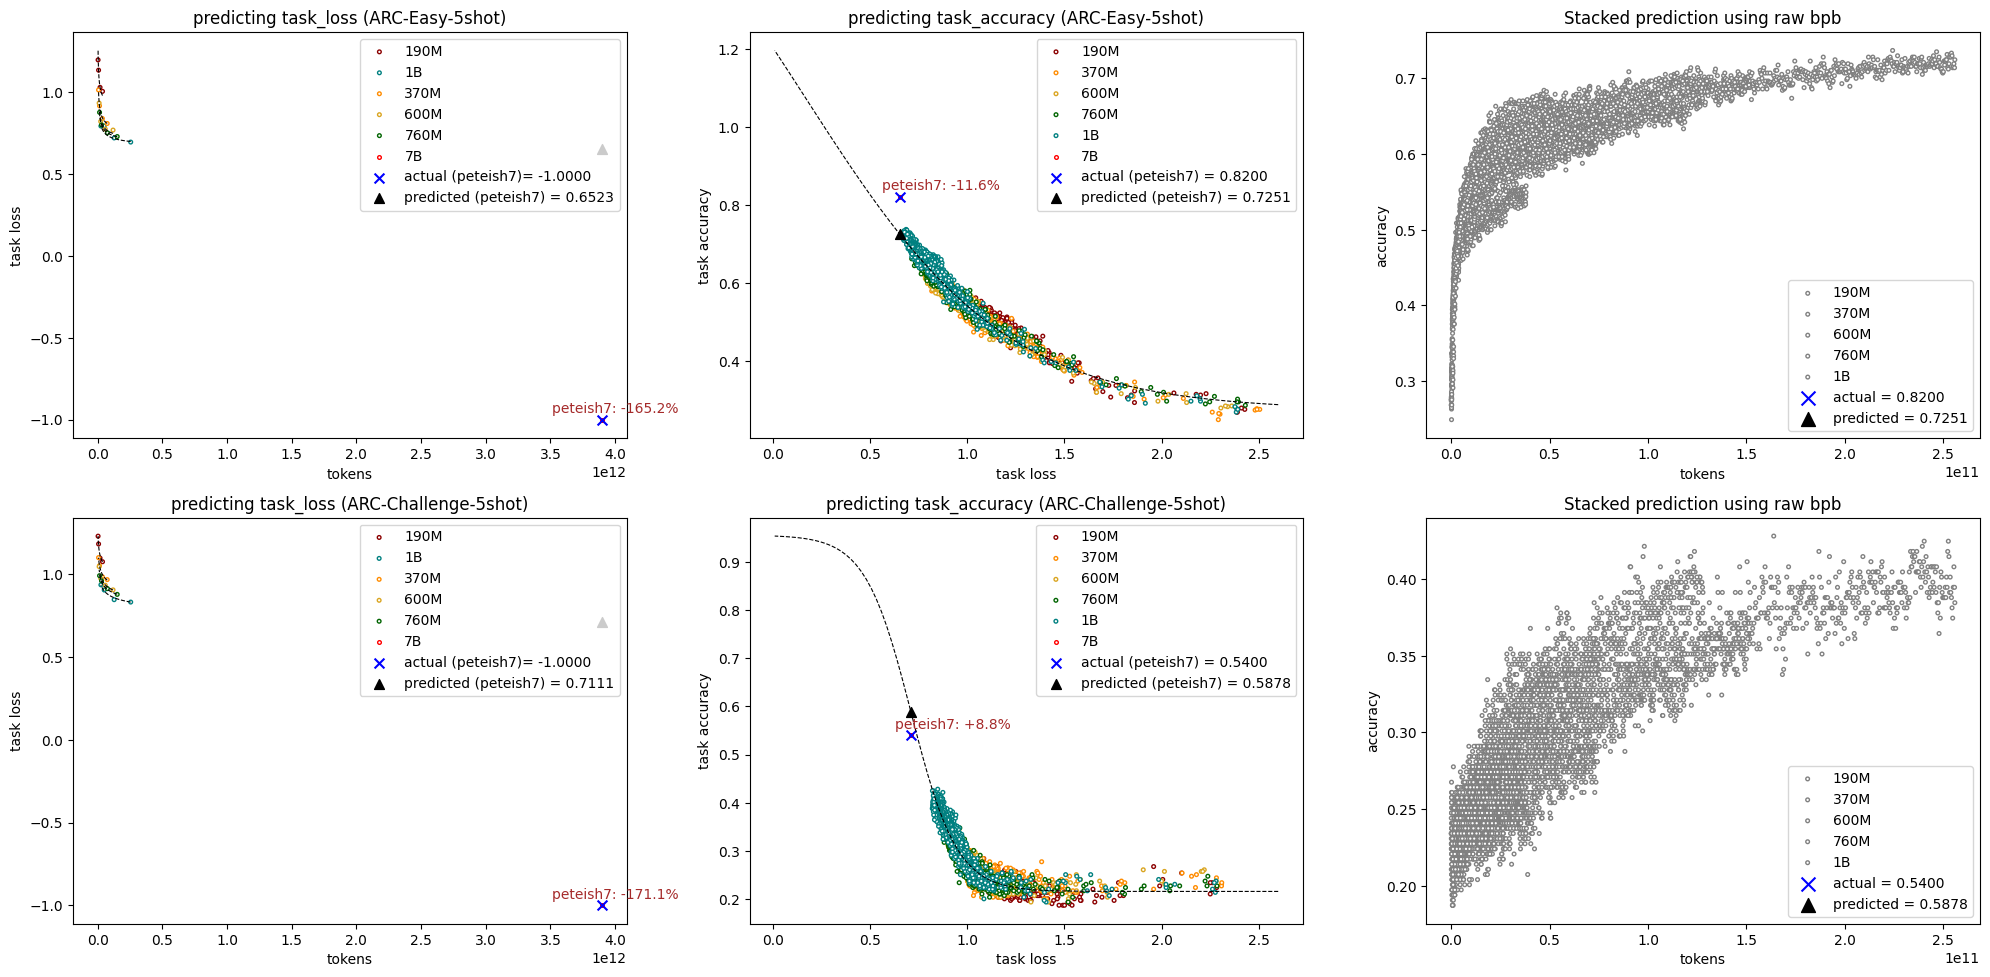

In [23]:
rows = len(TASKS.keys())
fig, axes = plt.subplots(rows, 3, figsize=(20, 5 * rows))

step1_error = {}
stacked_error = {}

eval_row_7b = {
    "tokens": 3895023632384.3335,
    "params": 6887575552,
    "size": "7B",
    "length": "full",
    "mode": "eval",
    "run": "peteish7"
}

# TODO: these are not 5-shot values
task_accs_7b = {
    "MMLU-Var": 0.46,
    "HellaSwag-5shot": 0.78,
    "ARC-Easy-5shot": 0.82,
    "ARC-Challenge-5shot": 0.54,
    "PiQA-5shot": 0.81,
    "Winogrande-5shot": 0.73,
    "OpenbookQA-5shot": 0.45,
    "SciQ-0shot": 0.96,
    "CSQA-5shot": -1,
    "SocialIQA-5shot": -1,
}

# eval_row_13b = {
#     "tokens": ,
#     "params": 13202396160,
#     "size": "13B",
#     "length": "full",
#     "mode": "eval",
#     "run": "peteish13"
# }

for configs in all_configs:
    #target = [run_name for run_name in configs if configs[run_name].mode == "eval"][0]
    #step1_error[target] = {}
    #stacked_error[target] = {}

    for i, (task_name, task) in enumerate(TASKS.items()):
        tokens = get_all_data_by_name(configs, ["throughput/total_tokens"])
        bpb_loss = get_all_data_by_name(configs, task['bpb'])
        downstream_loss = get_all_data_by_name(configs, task['score'])
    
        df = get_dataframe(configs, tokens, downstream_loss)

        eval_row = eval_row_7b
        task_accs = task_accs_7b
       
        step1_df = get_dataframe(configs, tokens, bpb_loss)
        step1_df.loc[len(step1_df)] = [eval_row["tokens"], -1, eval_row["params"], eval_row["size"], eval_row["length"], eval_row["mode"], eval_row["run"], 'r', 0.2]
        step1_df = step1_df.groupby('run').apply(lambda rows: rows.iloc[-1], include_groups=False).reset_index()
        step1_df, step1_coefficients = fit_step1(step1_df)

        do_plot = True #"1B-10xC" in configs
        if do_plot:
            plot_step1(
                step1_df,
                step1_coefficients,
                axes[i][0],
                x_label="tokens",
                y_label="task loss",
                title=f"predicting task_loss ({task_name})",
                do_label=True,
            )
        #step1_error[target][task_name] = get_predicted_error(step1_df)

        step2_df = get_dataframe(configs, bpb_loss, downstream_loss)
        step2_df.loc[len(step2_df)] = [eval_row["tokens"], task_accs[task_name], eval_row["params"], eval_row["size"], eval_row["length"], eval_row["mode"], eval_row["run"], 'r', 0.2]
        last_match_idx = step2_df.loc[step2_df["mode"]=="eval"].tail(1).index
        step2_df.loc[last_match_idx, 'x'] = step1_df[step1_df["mode"]=="eval"].predicted_y.values[0]
    
        step2_df, step2_coefficients = fit_step2(step2_df, BASELINE_BY_TASK_NAME[task_name])
        if do_plot:
            plot_step2(
                step2_df,
                step2_coefficients,
                axes[i][1], x_label="task loss",
                y_label="task accuracy",
                title=f"predicting task_accuracy ({task_name})",
                do_label=True,
            )
        # stacked_error[target][task_name] = get_predicted_error(step2_df)
    
        if do_plot:
            plot_stacked(df, step2_df, axes[i][2], title="Stacked prediction using raw bpb", do_label=True, do_grey=True)

# fig.suptitle('Combined 2-step downstream predictions', fontsize=12)
fig.tight_layout()
fig.subplots_adjust(top=0.95)

In [20]:
# from a_david_noise_utils import print_error_table
# print_error_table(stacked_error)